<a href="https://colab.research.google.com/github/Doppler-67/human_age_prediction/blob/main/faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, AveragePooling2D, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

# **Importing data**

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/faces/photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=128)

Found 7591 validated image filenames.


# **EDA**

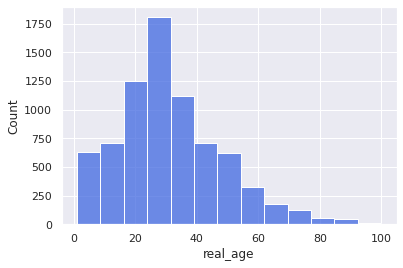

In [4]:
sns.histplot(x=labels['real_age'], bins=13, color='royalblue')
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
features, target = next(train_gen_flow)

Посмотрим на несколько изображений.

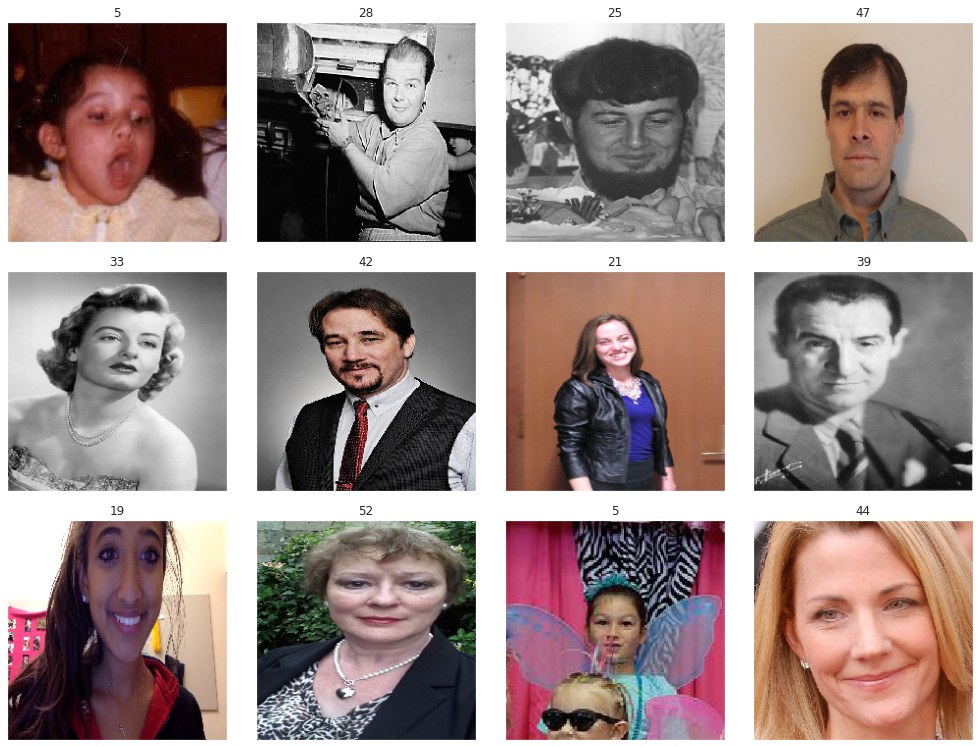

In [7]:
fig = plt.figure(figsize=(14,14))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете 7591 фотография людей. Максимальный возраст - 100 лет, минимальный возраст - 1 год, средний возраст - 31 год. Есть как цветные, так и черно-белые фотографии, на большинстве фото присутствуют посторонние предметы. Преимущественно, лица на фотографиях запечатлены крупным планом.

# **Preparation**

Модель будет учиться на удаленном сервере. Для удобства загрузку изображений, создание модели и ее обучение реализуем в виде функций.

Для обучения будем использовать базовые аугментации: horizontal_flip, crop и rotation.

In [8]:
def load_train(path):

    train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    height_shift_range=0.2, 
    width_shift_range=0.2) 

    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=67)
    
    return train_gen_flow

In [9]:
def load_test(path):

    test_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255)

    labels = pd.read_csv(path + 'labels.csv')
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'photos/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=67)
    
    return test_gen_flow

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
  
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

In [11]:
train = load_train('/content/drive/MyDrive/faces/')
test = load_test('/content/drive/MyDrive/faces/')

Found 6073 validated image filenames.
Found 1518 validated image filenames.


Задача регрессии для изображений - нетривиальная задача, поэтому успешные архитектуры для классификации могут быть плохи для регрессии. Попробуем три различные архитектуры CNN и подберем гиперпараметры:

1. Кастомная модель.
2. AlexNet.
3. ResNet50.

В качестве наивного решения попробуем взять медиану. Посчитаем MAE и уже потом его будем сравнивать с MAE моделей.

In [12]:
labels['median_age'] = labels['real_age'].median()

In [13]:
print('MAE:', round(mean_absolute_error(labels['real_age'], labels['median_age']),2))

MAE: 13.12


Для каждой модели будет выведена таблица с результатами, а также ход обучения лучшей комбинации гиперпараметров.

# **Custom model**

In [14]:
def create_model(input_shape, learning_rate=0.01):

    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', strides=2))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(Flatten())

    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model

In [15]:
model = create_model((224, 224, 3))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 1)                 401409    
                                                        

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 105s - loss: 18.9265 - mae: 18.9269 - val_loss: 13.3402 - val_mae: 13.3714
Epoch 2/20
190/190 - 104s - loss: 13.4054 - mae: 13.3992 - val_loss: 13.6359 - val_mae: 13.6555
Epoch 3/20
190/190 - 106s - loss: 13.4368 - mae: 13.4303 - val_loss: 12.9756 - val_mae: 12.9993
Epoch 4/20
190/190 - 103s - loss: 13.4394 - mae: 13.4316 - val_loss: 12.9439 - val_mae: 12.9665
Epoch 5/20
190/190 - 101s - loss: 13.3578 - mae: 13.3509 - val_loss: 14.6847 - val_mae: 14.7215
Epoch 6/20
190/190 - 103s - loss: 13.5122 - mae: 13.5037 - val_loss: 13.0010 - val_mae: 13.0195
Epoch 7/20
190/190 - 100s - loss: 13.4019 - mae: 13.3965 - val_loss: 12.9551 - val_mae: 12.9738
Epoch 8/20
190/190 - 101s - loss: 13.6742 - mae: 13.6647 - val_loss: 13.0746 - val_mae: 13.0932
Epoch 9/20
190/190 - 105s - loss: 13.3850 - mae: 13.3787 - val_loss: 12.9088 - val_mae: 12.9299
Epoch 10/20
190/190 - 105s - loss: 13.6129 - mae: 13.6048 - val_loss: 12.9450 - val_mae: 12.9676
Epoch 11/20
190/190 - 109s - loss: 13.3657 - mae: 13.3593 - val_loss: 12.9262 - val_mae: 12.9482
Epoch 12/20
190/190 - 105s - loss: 13.3050 - mae: 13.2976 - val_loss: 15.2309 - val_mae: 15.2675
Epoch 13/20
190/190 - 112s - loss: 13.3677 - mae: 13.3598 - val_loss: 13.8267 - val_mae: 13.8611
Epoch 14/20
190/190 - 111s - loss: 13.3824 - mae: 13.3760 - val_loss: 12.9680 - val_mae: 12.9915
Epoch 15/20
190/190 - 106s - loss: 13.3209 - mae: 13.3147 - val_loss: 13.2878 - val_mae: 13.3183
Epoch 16/20
190/190 - 105s - loss: 13.3260 - mae: 13.3200 - val_loss: 13.0126 - val_mae: 13.0374
Epoch 17/20
190/190 - 104s - loss: 13.3522 - mae: 13.3445 - val_loss: 13.8154 - val_mae: 13.8498
Epoch 18/20
190/190 - 95s - loss: 12.3243 - mae: 12.3176 - val_loss: 12.9871 - val_mae: 13.0112
Epoch 19/20
190/190 - 95s - loss: 10.3244 - mae: 10.3172 - val_loss: 11.1120 - val_mae: 11.1394
Epoch 20/20
190/190 - 94s - loss: 9.3706 - mae: 9.3647 - val_loss: 10.1197 - val_mae: 10.1201

48/48 - 8s - loss: 10.1197 - mae: 10.1201
Test MAE: 10.1201

```

|model|learning_rate|epochs|MAE|
|-|-|-|-|
|custom|0.01|10|13.83|
|custom|0.001|10|11.3|
|custom|0.0001|10|12.4|
|custom|0.01|20|12.75|
|**custom**|**0.001**|**20**|**10.12**|
|custom|0.0001|20|10.82|
|custom|0.01|30|12.91|
|custom|0.001|30|11.94|
|custom|0.0001|30|13.46|

Лучший результат удалось достичь при 20 эпохах и при learning_rate=0.001. Эта модель превзошла наивную модель. MAE 10.12 является неплохим результатом, но попробуем сделать его еще меньше.

# **Alexnet backbone + custom head**

In [17]:
def create_model(input_shape, learning_rate=0.01):

    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()

    model.add(Conv2D(96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    model.add(Conv2D(256, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(4096, activation='relu'))

    model.add(Dense(1000, activation='relu'))

    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model

In [18]:
model = create_model((224, 224, 3))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       2973952   
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                      

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/30
190/190 - 107s - loss: 16.7561 - mae: 16.7509 - val_loss: 15.2770 - val_mae: 15.2823
Epoch 2/30
190/190 - 92s - loss: 13.9889 - mae: 13.9819 - val_loss: 13.2859 - val_mae: 13.2938
Epoch 3/30
190/190 - 92s - loss: 13.5800 - mae: 13.5733 - val_loss: 15.1853 - val_mae: 15.1808
Epoch 4/30
190/190 - 92s - loss: 13.5599 - mae: 13.5566 - val_loss: 13.1015 - val_mae: 13.1308
Epoch 5/30
190/190 - 92s - loss: 13.2748 - mae: 13.2686 - val_loss: 14.0767 - val_mae: 14.1159
Epoch 6/30
190/190 - 92s - loss: 13.1381 - mae: 13.1314 - val_loss: 12.4887 - val_mae: 12.4866
Epoch 7/30
190/190 - 92s - loss: 13.1280 - mae: 13.1205 - val_loss: 13.0662 - val_mae: 13.0605
Epoch 8/30
190/190 - 92s - loss: 12.9160 - mae: 12.9082 - val_loss: 13.1288 - val_mae: 13.1526
Epoch 9/30
190/190 - 92s - loss: 12.9426 - mae: 12.9383 - val_loss: 13.2123 - val_mae: 13.2285
Epoch 10/30
190/190 - 92s - loss: 12.8711 - mae: 12.8647 - val_loss: 13.7426 - val_mae: 13.7423
Epoch 11/30
190/190 - 92s - loss: 12.8374 - mae: 12.8292 - val_loss: 12.6122 - val_mae: 12.6099
Epoch 12/30
190/190 - 92s - loss: 12.6946 - mae: 12.6881 - val_loss: 13.0097 - val_mae: 13.0227
Epoch 13/30
190/190 - 92s - loss: 12.5725 - mae: 12.5641 - val_loss: 12.2466 - val_mae: 12.2648
Epoch 14/30
190/190 - 92s - loss: 12.4946 - mae: 12.4909 - val_loss: 12.4742 - val_mae: 12.4679
Epoch 15/30
190/190 - 92s - loss: 12.4718 - mae: 12.4665 - val_loss: 12.4533 - val_mae: 12.4675
Epoch 16/30
190/190 - 92s - loss: 12.4030 - mae: 12.3985 - val_loss: 12.7302 - val_mae: 12.7209
Epoch 17/30
190/190 - 92s - loss: 12.4445 - mae: 12.4394 - val_loss: 12.6329 - val_mae: 12.6008
Epoch 18/30
190/190 - 92s - loss: 12.4034 - mae: 12.3975 - val_loss: 12.8031 - val_mae: 12.8013
Epoch 19/30
190/190 - 92s - loss: 12.4000 - mae: 12.3934 - val_loss: 11.9570 - val_mae: 11.9531
Epoch 20/30
190/190 - 92s - loss: 12.3430 - mae: 12.3388 - val_loss: 12.0628 - val_mae: 12.0789
Epoch 21/30
190/190 - 92s - loss: 12.1923 - mae: 12.1885 - val_loss: 12.3847 - val_mae: 12.3753
Epoch 22/30
190/190 - 92s - loss: 12.1263 - mae: 12.1209 - val_loss: 11.8291 - val_mae: 11.8295
Epoch 23/30
190/190 - 92s - loss: 12.0720 - mae: 12.0664 - val_loss: 11.6190 - val_mae: 11.6027
Epoch 24/30
190/190 - 93s - loss: 12.0023 - mae: 11.9988 - val_loss: 12.5927 - val_mae: 12.5988
Epoch 25/30
190/190 - 92s - loss: 11.9751 - mae: 11.9719 - val_loss: 11.6369 - val_mae: 11.6556
Epoch 26/30
190/190 - 92s - loss: 11.7642 - mae: 11.7587 - val_loss: 12.5034 - val_mae: 12.5262
Epoch 27/30
190/190 - 92s - loss: 11.8430 - mae: 11.8382 - val_loss: 12.0394 - val_mae: 12.0337
Epoch 28/30
190/190 - 92s - loss: 11.7462 - mae: 11.7403 - val_loss: 12.1943 - val_mae: 12.2022
Epoch 29/30
190/190 - 92s - loss: 11.7220 - mae: 11.7188 - val_loss: 12.5028 - val_mae: 12.5108
Epoch 30/30
190/190 - 93s - loss: 11.4890 - mae: 11.4839 - val_loss: 10.0823 - val_mae: 10.0811

48/48 - 7s - loss: 10.0823 - mae: 10.0811
Test MAE: 10.0811


```

|model|learning_rate|epochs|MAE|
|-|-|-|-|
|AlexNet|0.01|10|13.2|
|AlexNet|0.001|10|12.4|
|AlexNet|0.0001|10|11.5|
|AlexNet|0.01|20|14.3|
|AlexNet|0.001|20|13.5|
|AlexNet|0.0001|20|10.82|
|AlexNet|0.01|30|12.91|
|**AlexNet**|**0.001**|**30**|**10.08**|
|AlexNet|0.0001|30|11.9|

Лучший результат удалось достичь при 30 эпохах и при learning_rate=0.001. Эта модель превзошла наивную модель, а также незначительно превзошла кастомную модель.

# **ResNet 50 backbone + custom head**

backbone не замораживаем, так как при заморозке наблюдаются очень слабые результаты.

In [20]:
def create_model(input_shape, learning_rate=0.01):

    optimizer = Adam(learning_rate=learning_rate)
    backbone = ResNet50(input_shape=input_shape, include_top=False)
    
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(100, activation='relu'))

    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])
    return model

In [21]:
model = create_model((224, 224, 3))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 100)               204900    
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,792,713
Trainable params: 23,739,593
Non-trainable params: 53,120
_________________________________________________________________


```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 122s - loss: 11.0172 - mae: 11.0122 - val_loss: 21.1623 - val_mae: 21.1851
Epoch 2/20
190/190 - 95s - loss: 7.8011 - mae: 7.7991 - val_loss: 19.0213 - val_mae: 19.0431
Epoch 3/20
190/190 - 95s - loss: 7.1669 - mae: 7.1621 - val_loss: 10.8664 - val_mae: 10.8742
Epoch 4/20
190/190 - 94s - loss: 6.7013 - mae: 6.6962 - val_loss: 8.0973 - val_mae: 8.1024
Epoch 5/20
190/190 - 94s - loss: 6.3235 - mae: 6.3190 - val_loss: 6.9259 - val_mae: 6.9174
Epoch 6/20
190/190 - 94s - loss: 5.9278 - mae: 5.9238 - val_loss: 7.3134 - val_mae: 7.3069
Epoch 7/20
190/190 - 94s - loss: 5.5749 - mae: 5.5719 - val_loss: 6.4650 - val_mae: 6.4696
Epoch 8/20
190/190 - 94s - loss: 5.3591 - mae: 5.3559 - val_loss: 7.2608 - val_mae: 7.2613
Epoch 9/20
190/190 - 94s - loss: 5.1011 - mae: 5.0949 - val_loss: 7.9045 - val_mae: 7.8976
Epoch 10/20
190/190 - 95s - loss: 5.0281 - mae: 5.0260 - val_loss: 6.0340 - val_mae: 6.0304
Epoch 11/20
190/190 - 95s - loss: 4.5760 - mae: 4.5725 - val_loss: 6.5797 - val_mae: 6.5800
Epoch 12/20
190/190 - 96s - loss: 4.5630 - mae: 4.5597 - val_loss: 8.2730 - val_mae: 8.2925
Epoch 13/20
190/190 - 95s - loss: 4.2697 - mae: 4.2683 - val_loss: 6.7926 - val_mae: 6.7869
Epoch 14/20
190/190 - 95s - loss: 4.2694 - mae: 4.2671 - val_loss: 6.5699 - val_mae: 6.5797
Epoch 15/20
190/190 - 95s - loss: 4.0922 - mae: 4.0903 - val_loss: 6.1691 - val_mae: 6.1533
Epoch 16/20
190/190 - 95s - loss: 3.9855 - mae: 3.9850 - val_loss: 5.6165 - val_mae: 5.6203
Epoch 17/20
190/190 - 96s - loss: 3.7538 - mae: 3.7517 - val_loss: 5.8743 - val_mae: 5.8805
Epoch 18/20
190/190 - 95s - loss: 3.7172 - mae: 3.7165 - val_loss: 5.7603 - val_mae: 5.7666
Epoch 19/20
190/190 - 96s - loss: 3.5666 - mae: 3.5651 - val_loss: 6.0865 - val_mae: 6.0936
Epoch 20/20
190/190 - 95s - loss: 3.4190 - mae: 3.4175 - val_loss: 5.7188 - val_mae: 5.7136

48/48 - 8s - loss: 5.7188 - mae: 5.7136
Test MAE: 5.7136

```

|model|learning_rate|epochs|MAE|
|-|-|-|-|
|ResNet|0.01|10|10.8|
|ResNet|0.001|10|9.9|
|ResNet|0.0001|10|12.6|
|ResNet|0.01|20|8.3|
|ResNet|0.001|20|7.1|
|**ResNet**|**0.0001**|**20**|**5.7**|
|ResNet|0.01|30|6.8|
|ResNet|0.001|30|7.2|
|ResNet|0.0001|30|5.9|

Лучший результат удалось достичь при 20 эпохах и при learning_rate=0.0001. Эта модель оказалась очень удачная. Удалось получить 5.7 MAE.

# **Results**

**Финальная архитектура модели состоит из resnet50 backbone и кастомной головы. Для этой модели использовались уже предобученные веса. Модель обучалась батчами по 32 изображения. В качестве оптимизатора использовался Adam с lr=1e-4. Обучение происходило без заморозки backbone. Модель обучалась 20 эпох. В итоге удалось достичь 5.71 по метрике MAE. Учитывая, что в статье об этом наборе данных людям удалось получить 5.4 по MAE, то наша модель показала очень достойный результат и вплотную приблизилась к эталонному.**